In [1]:
from FeatureExtraction import *
import os
import pandas as pd
import numpy as np

In [2]:
data_dir = '/Users/jazlynn/Downloads/neurons-smr-format-sorted/'

results_dict = {'Filename': [],
                'firing rate': [],
                'ifr_mean': [],
                'ifr_skew': [],
                'ifr_kurtosis': [],
                'ifr_fano_factor': [],
                'ISI_mean': [],
                'ISI_skew': [],
                'ISI_kurtosis': [],
                'ISI_cv': [],
                'num_bursts': [], 
                'mean_surprise': [],
                'burst_index': [],
                'mean_burst_duration': [],
                'var_burst_duration': [],
                'mean_interburst_duration': [],
                'var_interburst_duration': [],
                'max_peak_freq': [],
                'delta_band': [],
                'theta_band': [],
                'alpha_band': [],
                'beta_band': [],
                'gamma_band': []}

for file in os.listdir(data_dir):
    if file.endswith('.smr'):
        analogsignal, spike_times, sampling_frequency, time = load_spiketrain(os.path.join(data_dir,file))
        results_dict['Filename'].append(file)
        
        results_dict['firing rate'].append(get_firing_rate(spike_times, analogsignal, sampling_frequency))
        ifr_ls, time_bins = calculate_instantaneous_firing_rate(spike_times, analogsignal, sampling_frequency, 0.05, 0.1)
        fano_factor, ifr_mean, ifr_skew, ifr_kurtosis = get_ifr_metrics(ifr_ls)
        results_dict['ifr_mean'].append(ifr_mean)
        results_dict['ifr_skew'].append(ifr_skew)
        results_dict['ifr_kurtosis'].append(ifr_kurtosis)
        results_dict['ifr_fano_factor'].append(fano_factor)
        
        ISI_cv, ISI_skew, ISI_kurtosis, ISI_mean, ISI_mode = get_ISI_metrics(spike_times)
        results_dict['ISI_cv'].append(ISI_cv)
        results_dict['ISI_skew'].append(ISI_skew)
        results_dict['ISI_kurtosis'].append(ISI_kurtosis)
        results_dict['ISI_mean'].append(ISI_mean)
        
        burst_dict = burst_detection_neuroexplorer(spike_times, 
                                                   analogsignal, 
                                                   sampling_frequency, 
                                                   min_surprise = 5, 
                                                   min_numspikes = 3)
        num_bursts, mean_surprise, burst_index_poisson, mean_burst_duration, var_burst_duration, mean_interburst_duration, var_interburst_duration = get_burst_metrics(burst_dict, spike_times)
        burst_index = get_burst_index(spike_times)
        results_dict['num_bursts'].append(num_bursts)
        results_dict['mean_surprise'].append(mean_surprise)
        results_dict['burst_index'].append(burst_index) # not using poisson surprise
        results_dict['mean_burst_duration'].append(mean_burst_duration)
        results_dict['var_burst_duration'].append(var_burst_duration)
        results_dict['mean_interburst_duration'].append(mean_interburst_duration)
        results_dict['var_interburst_duration'].append(var_interburst_duration)
        
        max_peak_freq, freq_peaks, peak_bands, freq_magnitude = get_synchrony_features2(spike_times, 
                                                                                       time_bin_size = 0.01, 
                                                                                       max_lag_time = 0.5, 
                                                                                       significance_level = 0.05, 
                                                                                       to_plot = False)
        results_dict['max_peak_freq'].append(max_peak_freq)
        results_dict['delta_band'].append(int('delta' in peak_bands))
        results_dict['theta_band'].append(int('theta' in peak_bands))
        results_dict['alpha_band'].append(int('alpha' in peak_bands))
        results_dict['beta_band'].append(int('beta' in peak_bands))
        results_dict['gamma_band'].append(int('gamma' in peak_bands))
        
        
results_df = pd.DataFrame(results_dict)
results_df.head()
results_df.to_csv('ExtractedFeatures_v3.csv')

/Users/jazlynn/opt/anaconda3/envs/NP/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jazlynn/opt/anaconda3/envs/NP/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jazlynn/opt/anaconda3/envs/NP/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jazlynn/opt/anaconda3/envs/NP/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jazlynn/opt/anaconda3/envs/NP/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Model Training

In [3]:
metadata = pd.read_csv('/Users/jazlynn/Downloads/bme1500-project-5-metadata.csv')
metadata

,Filename,Patient ID,Target,Neuron,Hemisphere
0,neuron_001.smr,1,STN,STN,R
1,neuron_002.smr,2,GPi,BOR,L
2,neuron_003.smr,3,GPi,BOR,R
3,neuron_004.smr,3,GPi,BOR,L
4,neuron_005.smr,3,GPi,BOR,L
...,...,...,...,...,...
355,neuron_356.smr,143,STN,STN,R
356,neuron_357.smr,143,STN,SNr,R
357,neuron_358.smr,144,STN,SNr,L
358,neuron_359.smr,145,STN,STN,R


In [98]:
results_df = pd.read_csv('ExtractedFeatures_v3.csv')

print(results_df.isnull().any())
results_df.fillna(0,inplace=True)

combined_data = pd.merge(metadata, results_df,on='Filename')
combined_data['type'] = combined_data['Neuron'] + '_' + combined_data['Hemisphere']
combined_data.head()

Unnamed: 0                  False
Filename                    False
firing rate                 False
ifr_mean                    False
ifr_skew                    False
ifr_kurtosis                False
ifr_fano_factor             False
ISI_mean                    False
ISI_skew                    False
ISI_kurtosis                False
ISI_cv                      False
num_bursts                  False
mean_surprise                True
burst_index                 False
mean_burst_duration          True
var_burst_duration           True
mean_interburst_duration     True
var_interburst_duration      True
max_peak_freq               False
delta_band                  False
theta_band                  False
alpha_band                  False
beta_band                   False
gamma_band                  False
dtype: bool


,Filename,Patient ID,Target,Neuron,Hemisphere,Unnamed: 0,firing rate,ifr_mean,ifr_skew,ifr_kurtosis,...,var_burst_duration,mean_interburst_duration,var_interburst_duration,max_peak_freq,delta_band,theta_band,alpha_band,beta_band,gamma_band,type
0,neuron_001.smr,1,STN,STN,R,300,13.520379,13.469388,1.020497,-0.052522,...,0.000000,0.000000,0.000000,2.969697,1,1,0,0,0,STN_R
1,neuron_002.smr,2,GPi,BOR,L,317,35.229484,35.046154,-0.017229,-0.250216,...,0.000043,0.801356,1.089216,2.969697,1,1,0,0,0,BOR_L
2,neuron_003.smr,3,GPi,BOR,R,314,18.319115,18.237179,0.172007,-0.105805,...,0.000000,0.000000,0.000000,2.969697,1,1,0,1,0,BOR_R
3,neuron_004.smr,3,GPi,BOR,L,352,16.787130,16.759142,0.123386,-0.008873,...,0.000000,0.000000,0.000000,2.484848,1,0,0,1,1,BOR_L
4,neuron_005.smr,3,GPi,BOR,L,351,10.208298,10.153374,0.343673,-0.355903,...,0.000000,0.000000,0.000000,2.484848,1,0,0,1,0,BOR_L


In [60]:
subset_left_STN = combined_data.loc[(combined_data['Hemisphere']=='L') & (combined_data['Target']=='STN')]
subset_left_GPi = combined_data.loc[(combined_data['Hemisphere']=='L') & (combined_data['Target']=='GPi')]
subset_right_STN = combined_data.loc[(combined_data['Hemisphere']=='R') & (combined_data['Target']=='STN')]
subset_right_GPi = combined_data.loc[(combined_data['Hemisphere']=='R') & (combined_data['Target']=='GPi')]

print('left STN', len(combined_data.loc[(combined_data['Hemisphere']=='L') & (combined_data['Neuron']=='STN')]))
print('right STN', len(combined_data.loc[(combined_data['Hemisphere']=='R') & (combined_data['Neuron']=='STN')]))
print('left SNr', len(combined_data.loc[(combined_data['Hemisphere']=='L') & (combined_data['Neuron']=='SNr')]))
print('right SNr', len(combined_data.loc[(combined_data['Hemisphere']=='R') & (combined_data['Neuron']=='SNr')]))
print('left HFD', len(combined_data.loc[(combined_data['Hemisphere']=='L') & (combined_data['Neuron']=='HFD')]))
print('right HFD', len(combined_data.loc[(combined_data['Hemisphere']=='R') & (combined_data['Neuron']=='HFD')]))
print('left BOR', len(combined_data.loc[(combined_data['Hemisphere']=='L') & (combined_data['Neuron']=='BOR')]))
print('right BOR', len(combined_data.loc[(combined_data['Hemisphere']=='R') & (combined_data['Neuron']=='BOR')]))

left STN 45
right STN 45
left SNr 45
right SNr 45
left HFD 45
right HFD 45
left BOR 45
right BOR 45


In [61]:
features = combined_data.columns
features = features.drop(['Filename','Unnamed: 0', 'Patient ID', 'Target', 'Neuron','Hemisphere','firing rate','type'])
print(features)

Index(['ifr_mean', 'ifr_skew', 'ifr_kurtosis', 'ifr_fano_factor', 'ISI_mean',
       'ISI_skew', 'ISI_kurtosis', 'ISI_cv', 'num_bursts', 'mean_surprise',
       'burst_index', 'mean_burst_duration', 'var_burst_duration',
       'mean_interburst_duration', 'var_interburst_duration', 'max_peak_freq',
       'delta_band', 'theta_band', 'alpha_band', 'beta_band', 'gamma_band'],
      dtype='object')


In [187]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.svm import SVC

#### Feature selection then hyperparam optimization

In [289]:
for population in [subset_left_GPi,subset_right_GPi,subset_left_STN,subset_right_STN]:
    print('Classifying region ' + population['Target'].iloc[0] + ' hemi ' + population['Hemisphere'].iloc[0])
    X_train, X_test, y_train, y_test = train_test_split(population[features],
                                                        population['Neuron'],
                                                        stratify=population['Neuron'],
                                                        test_size=0.2, random_state=42)
    RF = RandomForestClassifier(n_estimators=100, random_state=42)
    RF.fit(X_train, y_train)
    train_pred = RF.predict(X_train)
    test_pred = RF.predict(X_test)
    print('train accuracy', accuracy_score(y_train,train_pred))
    print('test accuracy', accuracy_score(y_test,test_pred))
    # cm = confusion_matrix(y_test, test_pred, labels=RF.classes_)
    # ConfusionMatrixDisplay.from_estimator(RF,X_test, y_test, labels=RF.classes_,cmap='gray')
    
    feature_importance = pd.DataFrame({'feature': RF.feature_names_in_, 'importance':RF.feature_importances_})
    feature_importance = feature_importance.sort_values(by='importance',ascending=False)
    # fig = sns.barplot(data=feature_importance,x='feature',y='importance')
    # plt.xticks(rotation=90)
    # plt.savefig('feature_importance_' + population['Target'].iloc[0] + ' hemi ' + population['Hemisphere'].iloc[0] + '.svg')
    
    
    pruned_features = feature_importance['feature'].iloc[:4].tolist()
    print('selected features', pruned_features)
    
    RF = RandomForestClassifier(n_estimators=100, random_state=42)
    RF.fit(X_train[pruned_features], y_train)
    train_pred = RF.predict(X_train[pruned_features])
    test_pred = RF.predict(X_test[pruned_features])
    print('pruned train accuracy', accuracy_score(y_train,train_pred))
    print('pruned test accuracy', accuracy_score(y_test,test_pred))
    
    parameters = {'n_estimators':[100,200,400], 'max_depth': [5,10,None],'min_samples_leaf': [0.001,0.01,0.1],'min_samples_split': [0.001,0.01,0.1]}
    RF_pruned = RandomForestClassifier(random_state=42)
    hypparam_opt = GridSearchCV(RF_pruned,parameters,cv=5,scoring='accuracy',refit=True,n_jobs=4)
    hypparam_opt.fit(X_train[pruned_features],y_train)
    
    # print(hypparam_opt.cv_results_)
    
    # opt_train_pred = hypparam_opt.predict(X_train[pruned_features])
    opt_test_pred = hypparam_opt.predict(X_test[pruned_features])
    # cm = confusion_matrix(y_test, opt_test_pred, labels=hypparam_opt.classes_)
    # ConfusionMatrixDisplay.from_estimator(hypparam_opt,X_test[pruned_features], y_test, labels=hypparam_opt.classes_,cmap='gray')
    # plt.savefig('Confusion_' + population['Target'].iloc[0] + ' hemi ' + population['Hemisphere'].iloc[0] + '.svg')
    # print('optimized train accuracy', accuracy_score(y_train,opt_train_pred))
    # print('optimized test accuracy', accuracy_score(y_test,opt_test_pred))
    
    # fig,ax=plt.subplots()
    # sns.barplot(feature_importance,x='feature',y='importance',ax=ax)
    # ax.set_ylabel('Gini importance')
    # ax.tick_params(axis='x', labelrotation = 90)
    
    ### baseline model ###
    # print('baseline logistic regression')
    # LR = LogisticRegression(random_state=42, max_iter=200)
    # LR.fit(X_train, y_train)
    # train_pred = LR.predict(X_train)
    # test_pred = LR.predict(X_test)
    # print('all feat baseline train accuracy', accuracy_score(y_train,train_pred))
    # print('all feat baseline test accuracy', accuracy_score(y_test,test_pred))
    
    # print('baseline logistic regression optimized features')
    # LR = LogisticRegression(random_state=42, max_iter=150,penalty=None)
    # LR.fit(X_train[pruned_features], y_train)
    # train_pred = LR.predict(X_train[pruned_features])
    # test_pred = LR.predict(X_test[pruned_features])
    # print('baseline train accuracy', accuracy_score(y_train,train_pred))
    # print('baseline test accuracy', accuracy_score(y_test,test_pred))
    
    ### SVM ###
    # print('SVM model')
    # print('SVM before optimization')
    # svm = SVC(gamma='auto',random_state=42)
    # svm.fit(X_train[pruned_features], y_train)
    # train_pred = svm.predict(X_train[pruned_features])
    # test_pred = svm.predict(X_test[pruned_features])
    
    # pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(gamma='auto',random_state=42))])
    # pipe.fit(X_train[pruned_features], y_train)
    # train_pred = pipe.predict(X_train[pruned_features])
    # test_pred = pipe.predict(X_test[pruned_features])
    
    # print('svm train accuracy', accuracy_score(y_train,train_pred))
    # print('svm test accuracy', accuracy_score(y_test,test_pred))
    
    # svm_parameters = {'svc__C': [0.1, 1, 10], 'svc__gamma': [1, 0.1, 0.01, 0.001]}
    # # SVM_pruned = SVC(random_state=42,kernel='rbf')
    # # SVM_hypparam_opt = GridSearchCV(SVM_pruned,svm_parameters,cv=5,scoring='accuracy',refit=True,n_jobs=4)
    # # SVM_hypparam_opt.fit(X_train[pruned_features],y_train)
    
    # pipe_pruned = Pipeline([('scaler', StandardScaler()), ('svc', SVC(random_state=42))])
    # SVM_hypparam_opt = GridSearchCV(pipe_pruned,svm_parameters,cv=5,scoring='accuracy',refit=True,n_jobs=4)
    # SVM_hypparam_opt.fit(X_train[pruned_features],y_train)
    
    # opt_train_pred = SVM_hypparam_opt.predict(X_train[pruned_features])
    # opt_test_pred = SVM_hypparam_opt.predict(X_test[pruned_features], pos_label=population['Neuron'].iloc[0])
    # print('SVM optimized train accuracy', accuracy_score(y_train,opt_train_pred))
    # print('SVM optimized test accuracy', accuracy_score(y_test,opt_test_pred))

Classifying region GPi hemi L
train accuracy 1.0
test accuracy 0.8888888888888888
selected features ['ISI_mean', 'ifr_mean', 'mean_surprise', 'mean_burst_duration']
pruned train accuracy 1.0
pruned test accuracy 0.8888888888888888
{'mean_fit_time': array([0.06759267, 0.13814011, 0.2480628 , 0.06283255, 0.12686672,
       0.26333919, 0.06429639, 0.1226192 , 0.27146387, 0.07067394,
       0.13969612, 0.25228524, 0.06225777, 0.12236319, 0.24489799,
       0.06201711, 0.12462626, 0.24787297, 0.0651886 , 0.12304864,
       0.24450636, 0.06235504, 0.12226105, 0.25483093, 0.06183729,
       0.13663568, 0.28808122, 0.06660643, 0.12307162, 0.24612288,
       0.0627986 , 0.12340279, 0.24364471, 0.06208482, 0.12247963,
       0.24878998, 0.06260056, 0.12257805, 0.24425035, 0.06149726,
       0.12288804, 0.24598727, 0.06363678, 0.12290831, 0.24382181,
       0.06195111, 0.12245984, 0.24457741, 0.06221085, 0.12278285,
       0.24413209, 0.0622539 , 0.12276373, 0.24331889, 0.06233935,
       0.12291

#### What if dont split hemisphere

Classifying region GPi hemi L
train accuracy 1.0
test accuracy 0.8888888888888888
selected features ['ISI_mean', 'ifr_mean', 'mean_surprise', 'var_burst_duration']
pruned train accuracy 1.0
pruned test accuracy 0.9444444444444444
optimized train accuracy 0.9791666666666666
optimized test accuracy 0.8888888888888888
baseline logistic regression optimized features
baseline train accuracy 0.9444444444444444
baseline test accuracy 0.8611111111111112
SVM model
SVM before optimization
svm train accuracy 0.9791666666666666
svm test accuracy 0.8888888888888888
SVM optimized train accuracy 0.9791666666666666
SVM optimized test accuracy 0.8888888888888888
Classifying region STN hemi R
train accuracy 1.0
test accuracy 0.9444444444444444
selected features ['ISI_mean', 'ifr_mean', 'mean_surprise', 'burst_index']
pruned train accuracy 1.0
pruned test accuracy 0.9444444444444444
optimized train accuracy 0.9722222222222222
optimized test accuracy 0.9444444444444444
baseline logistic regression optimiz

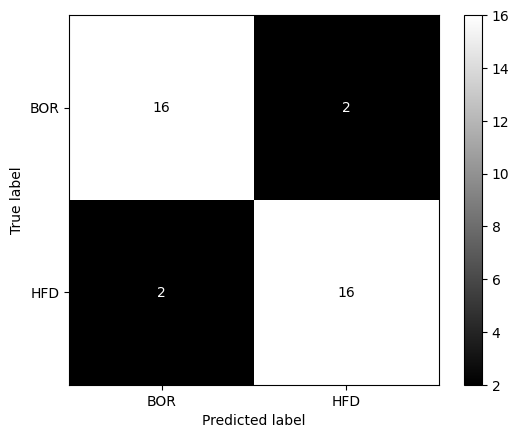

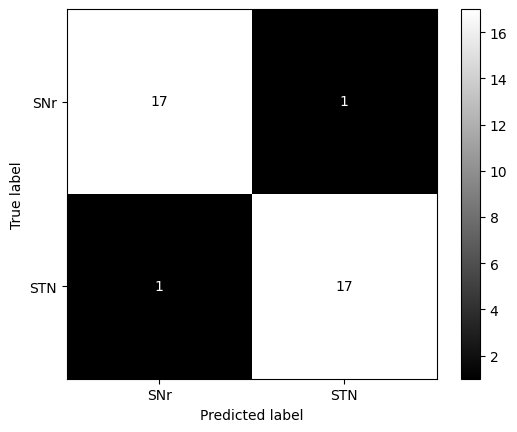

In [134]:
subset_STN = combined_data.loc[(combined_data['Target']=='STN')]
subset_GPi = combined_data.loc[(combined_data['Target']=='GPi')]

for population in [subset_GPi,subset_STN]:
    print('Classifying region ' + population['Target'].iloc[0] + ' hemi ' + population['Hemisphere'].iloc[0])
    X_train, X_test, y_train, y_test = train_test_split(population[features],
                                                        population['Neuron'],
                                                        stratify=population['Neuron'],
                                                        test_size=0.2, random_state=42)
    RF = RandomForestClassifier(n_estimators=100, random_state=42)
    RF.fit(X_train, y_train)
    train_pred = RF.predict(X_train)
    test_pred = RF.predict(X_test)
    print('train accuracy', accuracy_score(y_train,train_pred))
    print('test accuracy', accuracy_score(y_test,test_pred))
    cm = confusion_matrix(y_test, test_pred, labels=RF.classes_)
    ConfusionMatrixDisplay.from_estimator(RF,X_test, y_test, labels=RF.classes_,cmap='gray')
    
    feature_importance = pd.DataFrame({'feature': RF.feature_names_in_, 'importance':RF.feature_importances_})
    feature_importance = feature_importance.sort_values(by='importance',ascending=False)
    
    pruned_features = feature_importance['feature'].iloc[:4].tolist()
    print('selected features', pruned_features)
    
    RF = RandomForestClassifier(n_estimators=100, random_state=42)
    RF.fit(X_train[pruned_features], y_train)
    train_pred = RF.predict(X_train[pruned_features])
    test_pred = RF.predict(X_test[pruned_features])
    print('pruned train accuracy', accuracy_score(y_train,train_pred))
    print('pruned test accuracy', accuracy_score(y_test,test_pred))
    
    parameters = {'n_estimators':[100,200,400], 'max_depth': [5,10,None],'min_samples_leaf': [0.001,0.01,0.1],'min_samples_split': [0.001,0.01,0.1]}
    RF_pruned = RandomForestClassifier(random_state=42)
    hypparam_opt = GridSearchCV(RF_pruned,parameters,cv=5,scoring='accuracy',refit=True,n_jobs=4)
    hypparam_opt.fit(X_train[pruned_features],y_train)
    
    opt_train_pred = hypparam_opt.predict(X_train[pruned_features])
    opt_test_pred = hypparam_opt.predict(X_test[pruned_features])
    print('optimized train accuracy', accuracy_score(y_train,opt_train_pred))
    print('optimized test accuracy', accuracy_score(y_test,opt_test_pred))
    
    # fig,ax=plt.subplots()
    # sns.barplot(feature_importance,x='feature',y='importance',ax=ax)
    # ax.set_ylabel('Gini importance')
    # ax.tick_params(axis='x', labelrotation = 90)
    
    ### baseline model ###
    
    print('baseline logistic regression optimized features')
    LR = LogisticRegression(random_state=42, max_iter=150,penalty=None)
    LR.fit(X_train[pruned_features], y_train)
    train_pred = LR.predict(X_train[pruned_features])
    test_pred = LR.predict(X_test[pruned_features])
    print('baseline train accuracy', accuracy_score(y_train,train_pred))
    print('baseline test accuracy', accuracy_score(y_test,test_pred))
    
    ### SVM ###
    print('SVM model')
    print('SVM before optimization')
    svm = SVC(gamma='auto',random_state=42)
    svm.fit(X_train[pruned_features], y_train)
    train_pred = svm.predict(X_train[pruned_features])
    test_pred = svm.predict(X_test[pruned_features])
    print('svm train accuracy', accuracy_score(y_train,train_pred))
    print('svm test accuracy', accuracy_score(y_test,test_pred))
    
    svm_parameters = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01, 0.001]}
    SVM_pruned = SVC(random_state=42,kernel='rbf')
    SVM_hypparam_opt = GridSearchCV(SVM_pruned,svm_parameters,cv=5,scoring='accuracy',refit=True,n_jobs=4)
    SVM_hypparam_opt.fit(X_train[pruned_features],y_train)
    
    opt_train_pred = SVM_hypparam_opt.predict(X_train[pruned_features])
    opt_test_pred = SVM_hypparam_opt.predict(X_test[pruned_features])
    print('SVM optimized train accuracy', accuracy_score(y_train,opt_train_pred))
    print('SVM optimized test accuracy', accuracy_score(y_test,opt_test_pred))

#### can left side generalise to right and vice versa?

In [148]:
print('train left GPi')
X_train, X_test, y_train, y_test = train_test_split(subset_left_GPi[features],
                                                        subset_left_GPi['Neuron'],
                                                        stratify=subset_left_GPi['Neuron'],
                                                        test_size=0.2, random_state=42)
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train, y_train)
train_pred = RF.predict(X_train)
test_pred = RF.predict(X_test)
print('train accuracy', accuracy_score(y_train,train_pred))
print('test accuracy', accuracy_score(y_test,test_pred))
# cm = confusion_matrix(y_test, test_pred, labels=RF.classes_)
# ConfusionMatrixDisplay.from_estimator(RF,X_test, y_test, labels=RF.classes_,cmap='gray')

feature_importance = pd.DataFrame({'feature': RF.feature_names_in_, 'importance':RF.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance',ascending=False)

pruned_features = feature_importance['feature'].iloc[:4].tolist()
print('selected features', pruned_features)

RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train[pruned_features], y_train)
train_pred = RF.predict(X_train[pruned_features])
test_pred = RF.predict(X_test[pruned_features])
print('pruned train accuracy', accuracy_score(y_train,train_pred))
print('pruned test accuracy', accuracy_score(y_test,test_pred))

parameters = {'n_estimators':[100,200,400], 'max_depth': [5,10,None],'min_samples_leaf': [0.001,0.01,0.1],'min_samples_split': [0.001,0.01,0.1]}
RF_pruned = RandomForestClassifier(random_state=42)
hypparam_opt = GridSearchCV(RF_pruned,parameters,cv=5,scoring='accuracy',refit=True,n_jobs=4)
hypparam_opt.fit(X_train[pruned_features],y_train)

opt_train_pred = hypparam_opt.predict(X_train[pruned_features])
opt_test_pred = hypparam_opt.predict(X_test[pruned_features])
print('optimized train accuracy', accuracy_score(y_train,opt_train_pred))
print('optimized test accuracy', accuracy_score(y_test,opt_test_pred))

right_pred = hypparam_opt.predict(subset_right_GPi[pruned_features])
print('right accuracy', accuracy_score(subset_right_GPi['Neuron'],right_pred))

# fig,ax=plt.subplots()
# sns.barplot(feature_importance,x='feature',y='importance',ax=ax)
# ax.set_ylabel('Gini importance')
# ax.tick_params(axis='x', labelrotation = 90)

print('train left STN')
X_train, X_test, y_train, y_test = train_test_split(subset_left_STN[features],
                                                        subset_left_STN['Neuron'],
                                                        stratify=subset_left_STN['Neuron'],
                                                        test_size=0.2, random_state=42)
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train, y_train)
train_pred = RF.predict(X_train)
test_pred = RF.predict(X_test)
print('train accuracy', accuracy_score(y_train,train_pred))
print('test accuracy', accuracy_score(y_test,test_pred))
# cm = confusion_matrix(y_test, test_pred, labels=RF.classes_)
# ConfusionMatrixDisplay.from_estimator(RF,X_test, y_test, labels=RF.classes_,cmap='gray')

feature_importance = pd.DataFrame({'feature': RF.feature_names_in_, 'importance':RF.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance',ascending=False)

pruned_features = feature_importance['feature'].iloc[:4].tolist()
print('selected features', pruned_features)

RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train[pruned_features], y_train)
train_pred = RF.predict(X_train[pruned_features])
test_pred = RF.predict(X_test[pruned_features])
print('pruned train accuracy', accuracy_score(y_train,train_pred))
print('pruned test accuracy', accuracy_score(y_test,test_pred))

parameters = {'n_estimators':[100,200,400], 'max_depth': [5,10,None],'min_samples_leaf': [0.001,0.01,0.1],'min_samples_split': [0.001,0.01,0.1]}
RF_pruned = RandomForestClassifier(random_state=42)
hypparam_opt = GridSearchCV(RF_pruned,parameters,cv=5,scoring='accuracy',refit=True,n_jobs=4)
hypparam_opt.fit(X_train[pruned_features],y_train)

opt_train_pred = hypparam_opt.predict(X_train[pruned_features])
opt_test_pred = hypparam_opt.predict(X_test[pruned_features])
print('optimized train accuracy', accuracy_score(y_train,opt_train_pred))
print('optimized test accuracy', accuracy_score(y_test,opt_test_pred))

right_pred = hypparam_opt.predict(subset_right_STN[pruned_features])
print('right accuracy', accuracy_score(subset_right_STN['Neuron'],right_pred))

# fig,ax=plt.subplots()
# sns.barplot(feature_importance,x='feature',y='importance',ax=ax)
# ax.set_ylabel('Gini importance')
# ax.tick_params(axis='x', labelrotation = 90)

print('train right GPi')
X_train, X_test, y_train, y_test = train_test_split(subset_right_GPi[features],
                                                        subset_right_GPi['Neuron'],
                                                        stratify=subset_right_GPi['Neuron'],
                                                        test_size=0.2, random_state=42)
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train, y_train)
train_pred = RF.predict(X_train)
test_pred = RF.predict(X_test)
print('train accuracy', accuracy_score(y_train,train_pred))
print('test accuracy', accuracy_score(y_test,test_pred))
# cm = confusion_matrix(y_test, test_pred, labels=RF.classes_)
# ConfusionMatrixDisplay.from_estimator(RF,X_test, y_test, labels=RF.classes_,cmap='gray')

feature_importance = pd.DataFrame({'feature': RF.feature_names_in_, 'importance':RF.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance',ascending=False)

pruned_features = feature_importance['feature'].iloc[:4].tolist()
print('selected features', pruned_features)

RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train[pruned_features], y_train)
train_pred = RF.predict(X_train[pruned_features])
test_pred = RF.predict(X_test[pruned_features])
print('pruned train accuracy', accuracy_score(y_train,train_pred))
print('pruned test accuracy', accuracy_score(y_test,test_pred))

parameters = {'n_estimators':[100,200,400], 'max_depth': [5,10,None],'min_samples_leaf': [0.001,0.01,0.1],'min_samples_split': [0.001,0.01,0.1]}
RF_pruned = RandomForestClassifier(random_state=42)
hypparam_opt = GridSearchCV(RF_pruned,parameters,cv=5,scoring='accuracy',refit=True,n_jobs=4)
hypparam_opt.fit(X_train[pruned_features],y_train)

opt_train_pred = hypparam_opt.predict(X_train[pruned_features])
opt_test_pred = hypparam_opt.predict(X_test[pruned_features])
print('optimized train accuracy', accuracy_score(y_train,opt_train_pred))
print('optimized test accuracy', accuracy_score(y_test,opt_test_pred))

left_pred = hypparam_opt.predict(subset_left_GPi[pruned_features])
print('left accuracy', accuracy_score(subset_left_GPi['Neuron'],left_pred))

# fig,ax=plt.subplots()
# sns.barplot(feature_importance,x='feature',y='importance',ax=ax)
# ax.set_ylabel('Gini importance')
# ax.tick_params(axis='x', labelrotation = 90)

print('train right STN')
X_train, X_test, y_train, y_test = train_test_split(subset_right_STN[features],
                                                        subset_right_STN['Neuron'],
                                                        stratify=subset_right_STN['Neuron'],
                                                        test_size=0.2, random_state=42)
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train, y_train)
train_pred = RF.predict(X_train)
test_pred = RF.predict(X_test)
print('train accuracy', accuracy_score(y_train,train_pred))
print('test accuracy', accuracy_score(y_test,test_pred))
# cm = confusion_matrix(y_test, test_pred, labels=RF.classes_)
# ConfusionMatrixDisplay.from_estimator(RF,X_test, y_test, labels=RF.classes_,cmap='gray')

feature_importance = pd.DataFrame({'feature': RF.feature_names_in_, 'importance':RF.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance',ascending=False)

pruned_features = feature_importance['feature'].iloc[:4].tolist()
print('selected features', pruned_features)

RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train[pruned_features], y_train)
train_pred = RF.predict(X_train[pruned_features])
test_pred = RF.predict(X_test[pruned_features])
print('pruned train accuracy', accuracy_score(y_train,train_pred))
print('pruned test accuracy', accuracy_score(y_test,test_pred))

parameters = {'n_estimators':[100,200,400], 'max_depth': [5,10,None],'min_samples_leaf': [0.001,0.01,0.1],'min_samples_split': [0.001,0.01,0.1]}
RF_pruned = RandomForestClassifier(random_state=42)
hypparam_opt = GridSearchCV(RF_pruned,parameters,cv=5,scoring='accuracy',refit=True,n_jobs=4)
hypparam_opt.fit(X_train[pruned_features],y_train)

opt_train_pred = hypparam_opt.predict(X_train[pruned_features])
opt_test_pred = hypparam_opt.predict(X_test[pruned_features])
print('optimized train accuracy', accuracy_score(y_train,opt_train_pred))
print('optimized test accuracy', accuracy_score(y_test,opt_test_pred))

left_pred = hypparam_opt.predict(subset_left_STN[pruned_features])
print('left accuracy', accuracy_score(subset_left_STN['Neuron'],left_pred))

# fig,ax=plt.subplots()
# sns.barplot(feature_importance,x='feature',y='importance',ax=ax)
# ax.set_ylabel('Gini importance')
# ax.tick_params(axis='x', labelrotation = 90)


train left GPi
train accuracy 1.0
test accuracy 0.8888888888888888
selected features ['ISI_mean', 'ifr_mean', 'mean_surprise', 'mean_burst_duration']
pruned train accuracy 1.0
pruned test accuracy 0.8888888888888888
optimized train accuracy 1.0
optimized test accuracy 0.8888888888888888
right accuracy 0.9666666666666667
train left STN
train accuracy 1.0
test accuracy 0.7222222222222222
selected features ['ISI_mean', 'ifr_mean', 'mean_surprise', 'var_burst_duration']
pruned train accuracy 1.0
pruned test accuracy 0.6666666666666666
optimized train accuracy 0.9583333333333334
optimized test accuracy 0.7222222222222222
right accuracy 0.8888888888888888
train right GPi
train accuracy 1.0
test accuracy 0.8888888888888888
selected features ['ISI_mean', 'ifr_mean', 'mean_surprise', 'num_bursts']
pruned train accuracy 1.0
pruned test accuracy 0.9444444444444444
optimized train accuracy 0.9583333333333334
optimized test accuracy 1.0
left accuracy 0.9222222222222223
train right STN
train accurac

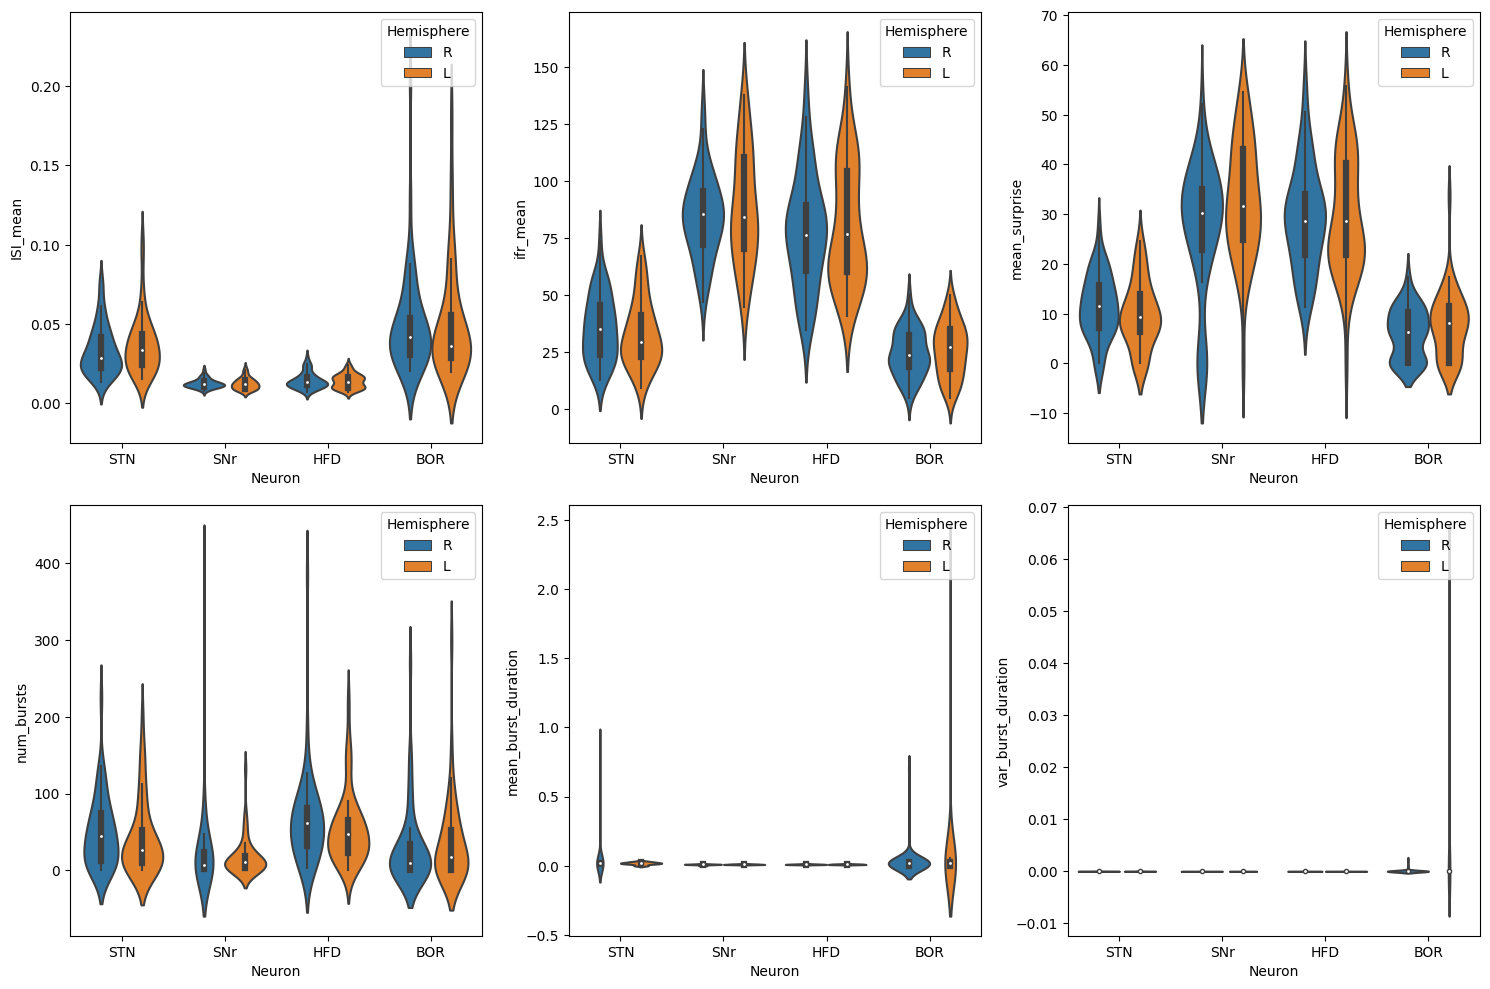

In [106]:
import seaborn as sns

fig,axes=plt.subplots(2,3,figsize=(15,10))
axes = axes.ravel()
for i, feat in enumerate(['ISI_mean', 'ifr_mean', 'mean_surprise', 'num_bursts','mean_burst_duration','var_burst_duration']):
    # sns.boxplot(subset_left_STN,x='Neuron',y=feat,ax=axes[i],showfliers=False,color='white')
    # sns.stripplot(subset_left_STN, x='Neuron', y=feat,ax=axes[i],hue='Neuron',legend=False)
    sns.violinplot(data=combined_data, x='Neuron', y=feat,hue='Hemisphere',legend=False,ax=axes[i], order=['STN','SNr','HFD','BOR'],palette='tab10')

fig.tight_layout()

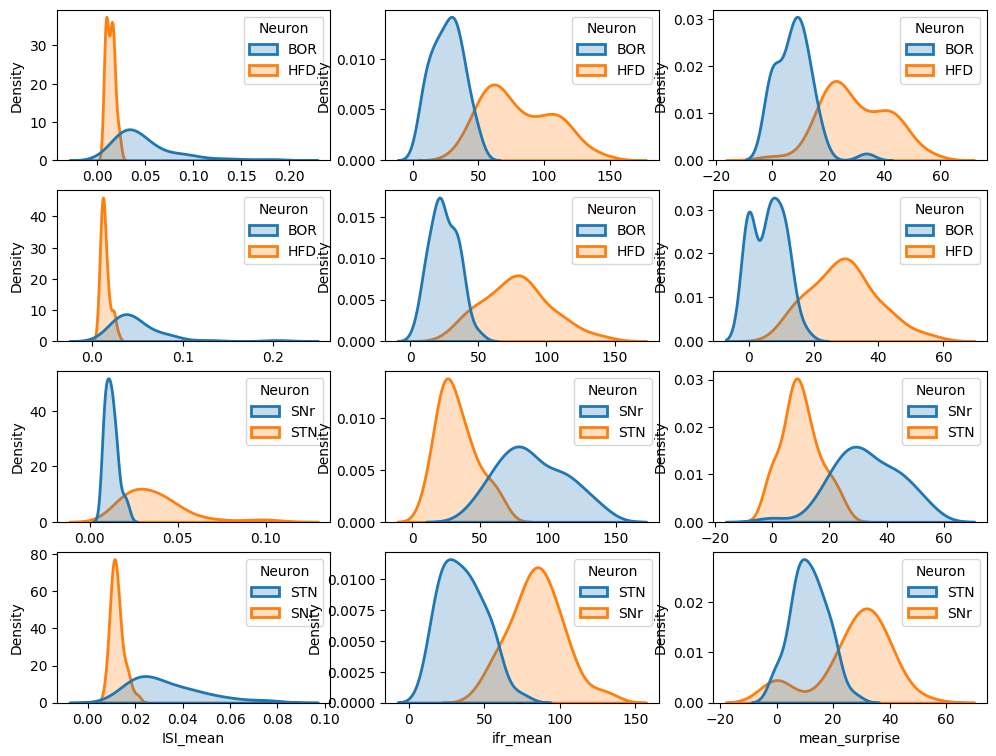

In [143]:
fig,axes=plt.subplots(4,3,figsize=(12,9))
for i,population in enumerate([subset_left_GPi,subset_right_GPi,subset_left_STN,subset_right_STN]):
    sns.kdeplot(population,x='ISI_mean',hue='Neuron',fill=True,linewidth=2,ax=axes[i,0])
    sns.kdeplot(population,x='ifr_mean',hue='Neuron',fill=True,linewidth=2,ax=axes[i,1])
    sns.kdeplot(population,x='mean_surprise',hue='Neuron',fill=True,linewidth=2,ax=axes[i,2])

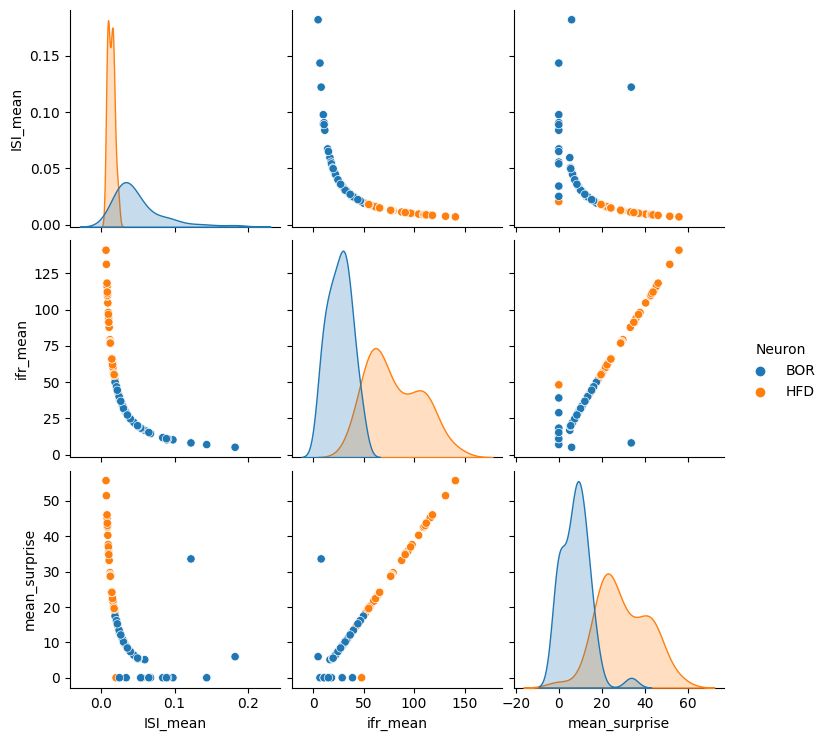

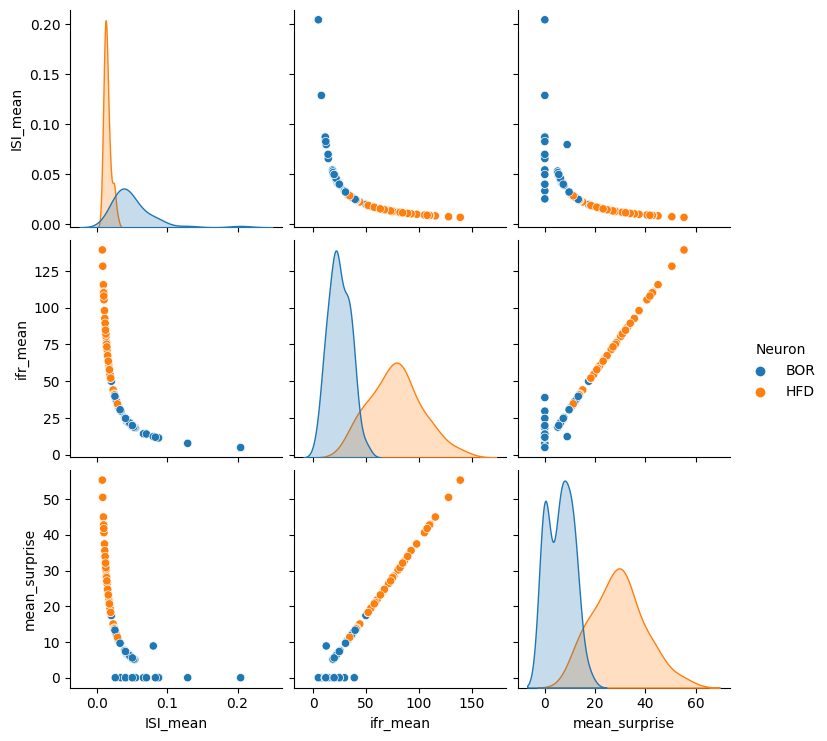

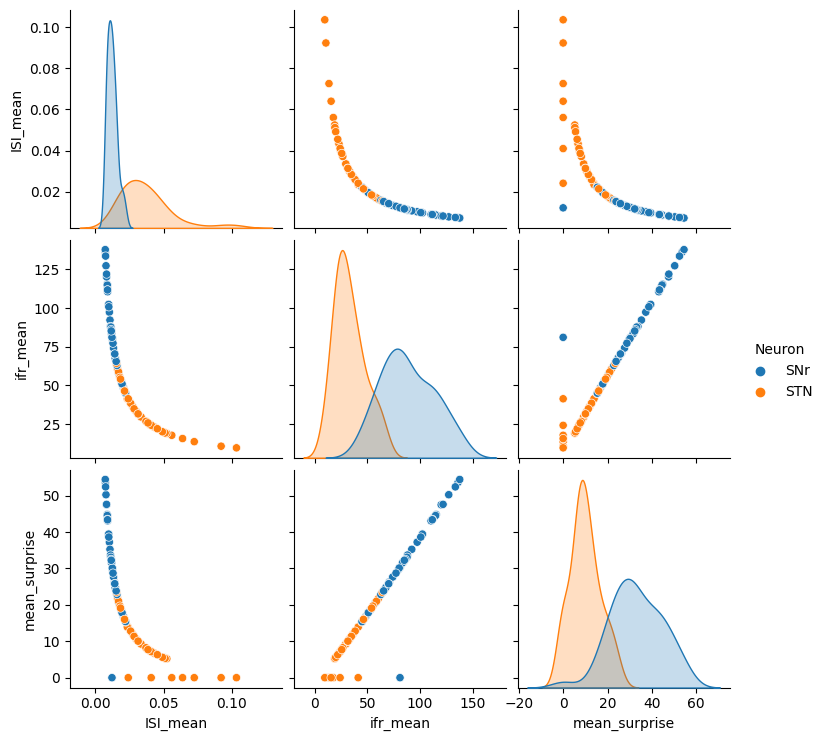

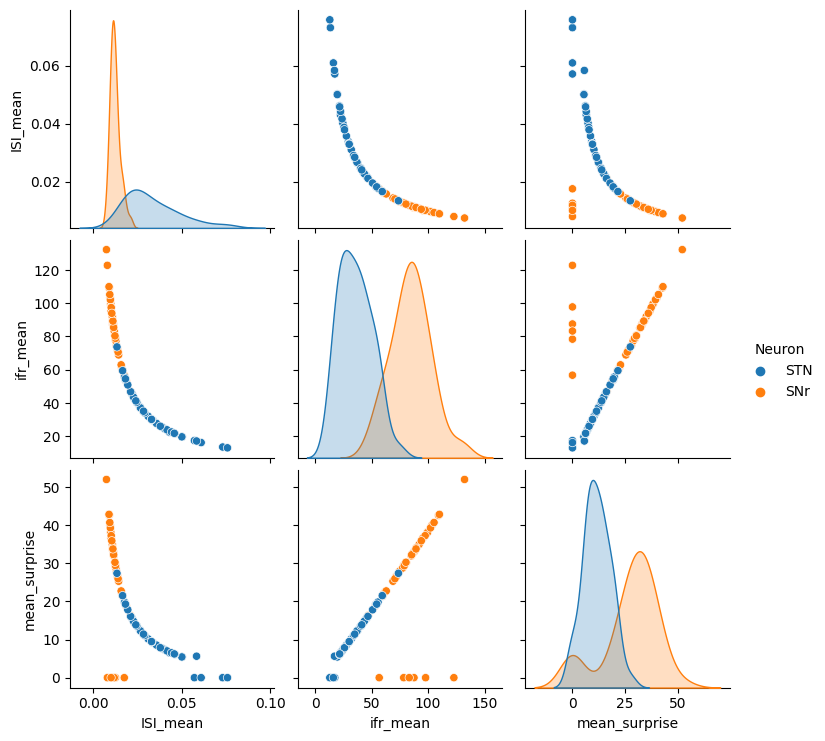

In [116]:
for i,population in enumerate([subset_left_GPi,subset_right_GPi,subset_left_STN,subset_right_STN]):
    sns.pairplot(population[['ISI_mean', 'ifr_mean', 'mean_surprise','Neuron']],hue='Neuron')

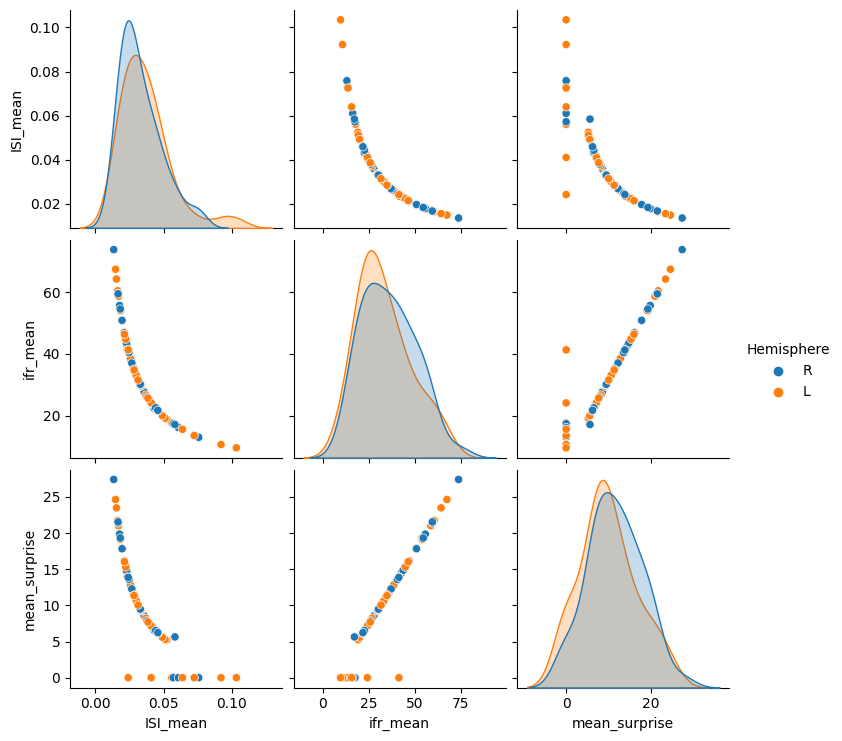

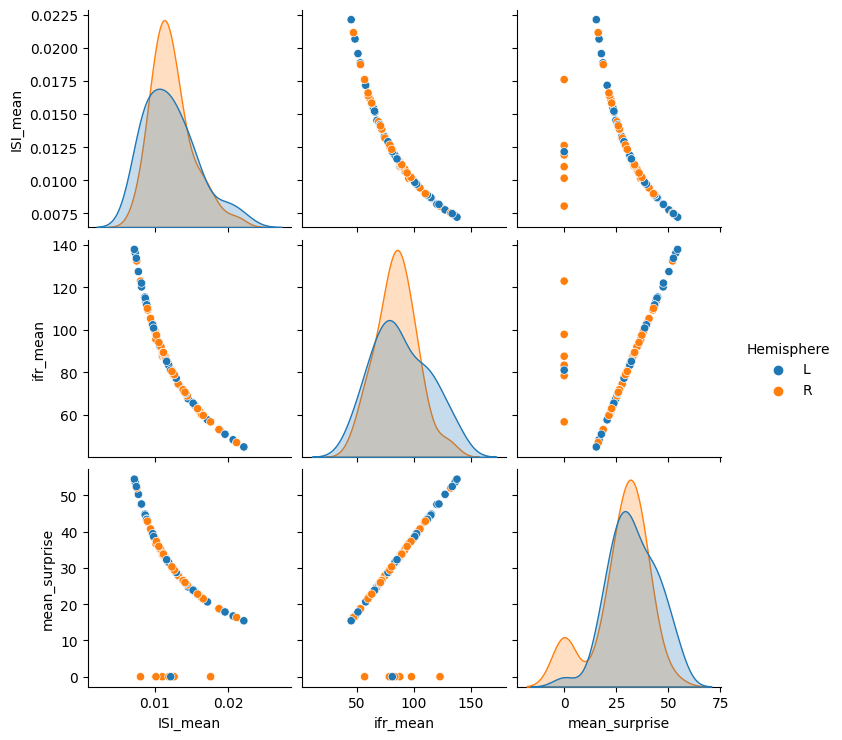

In [146]:
subset_STN_STN = combined_data.loc[combined_data['Neuron']=='STN']
subset_STN_SNr = combined_data.loc[combined_data['Neuron']=='SNr']
for i,population in enumerate([subset_STN_STN, subset_STN_SNr]):
    sns.pairplot(population[['ISI_mean', 'ifr_mean', 'mean_surprise','Hemisphere']],hue='Hemisphere')

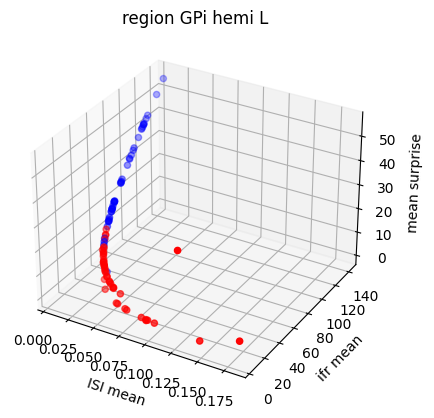

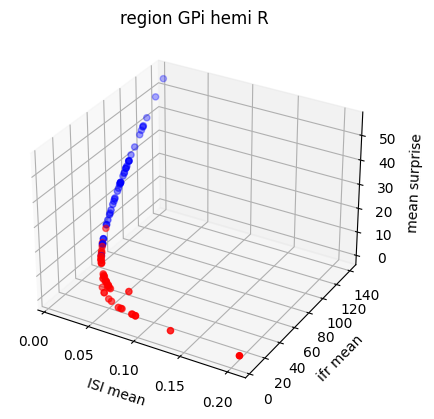

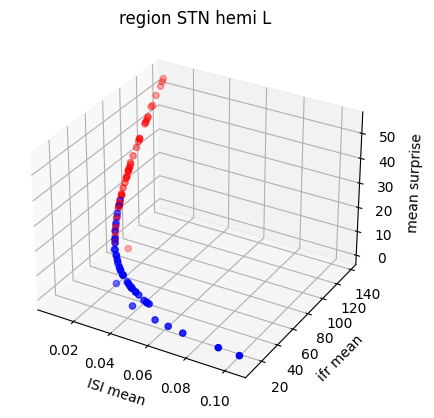

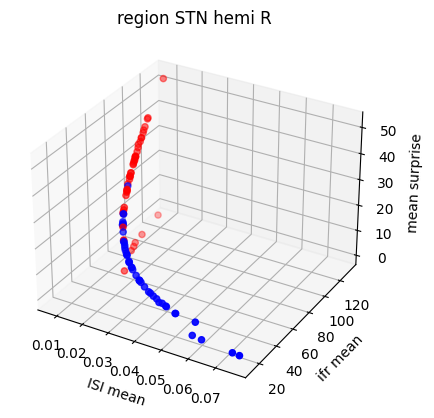

In [112]:

for i,population in enumerate([subset_left_GPi,subset_right_GPi,subset_left_STN,subset_right_STN]):
    # population['temp_class'] = 0
    classes = np.unique(population['Neuron'])
    color_dict = {classes[0]: 'red', classes[1]:'blue'}
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(population['ISI_mean'],population['ifr_mean'],population['mean_surprise'],c=[ color_dict[i] for i in population['Neuron'] ])
    ax.set_title('region ' + population['Target'].iloc[0] + ' hemi ' + population['Hemisphere'].iloc[0])
    ax.set_xlabel('ISI mean')
    ax.set_ylabel('ifr mean')
    ax.set_zlabel('mean surprise')


In [33]:

from sklearn.svm import SVC
svm_clf = SVC(gamma='auto',random_state=42)
svm_clf.fit(X_train, y_train)

SVM_train_pred = svm_clf.predict(X_train)
SVM_test_pred = svm_clf.predict(X_test)

print('train precision:', precision_score(y_train,SVM_train_pred,average=None))
print('train recall:', recall_score(y_train,SVM_train_pred,average=None))
print('train f1:', f1_score(y_train,SVM_train_pred,average=None))
matrix = confusion_matrix(y_train, SVM_train_pred)
print('train accuracy:', matrix.diagonal()/matrix.sum(axis=1))

print('test precision:', precision_score(y_test,SVM_test_pred,average=None))
print('test recall:', recall_score(y_test,SVM_test_pred,average=None))
print('test f1:', f1_score(y_test,SVM_test_pred,average=None))
matrix = confusion_matrix(y_test, SVM_test_pred)
print('test accuracy:', matrix.diagonal()/matrix.sum(axis=1))

print('macro averaged')
print('train precision:', precision_score(y_train,SVM_train_pred,average='macro'))
print('train recall:', recall_score(y_train,SVM_train_pred,average='macro'))
print('train f1:', f1_score(y_train,SVM_train_pred,average='macro'))
print('train accuracy', accuracy_score(y_train,SVM_train_pred))

print('test precision:', precision_score(y_test,SVM_test_pred,average='macro'))
print('test recall:', recall_score(y_test,SVM_test_pred,average='macro'))
print('test f1:', f1_score(y_test,SVM_test_pred,average='macro'))
print('test accuracy', accuracy_score(y_test,SVM_test_pred))

train precision: [0.98630137 1.         1.         1.        ]
train recall: [1.         1.         1.         0.98611111]
train f1: [0.99310345 1.         1.         0.99300699]
train accuracy: [1.         1.         1.         0.98611111]
test precision: [0.33333333 0.31818182 0.6        0.5       ]
test recall: [0.22222222 0.77777778 0.33333333 0.16666667]
test f1: [0.26666667 0.4516129  0.42857143 0.25      ]
test accuracy: [0.22222222 0.77777778 0.33333333 0.16666667]
macro averaged
train precision: 0.9965753424657534
train recall: 0.9965277777777778
train f1: 0.9965276103207138
train accuracy 0.9965277777777778
test precision: 0.43787878787878787
test recall: 0.375
test f1: 0.3492127496159754
test accuracy 0.375


In [39]:
from sklearn.ensemble import GradientBoostingClassifier
GBDT = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.005, max_depth=None, random_state=42,verbose=2).fit(X_train, y_train)

GBDT_train_pred = GBDT.predict(X_train)
GBDT_test_pred = GBDT.predict(X_test)

print('train precision:', precision_score(y_train,GBDT_train_pred,average=None))
print('train recall:', recall_score(y_train,GBDT_train_pred,average=None))
print('train f1:', f1_score(y_train,GBDT_train_pred,average=None))
matrix = confusion_matrix(y_train, GBDT_train_pred)
print('train accuracy:', matrix.diagonal()/matrix.sum(axis=1))

print('test precision:', precision_score(y_test,GBDT_test_pred,average=None))
print('test recall:', recall_score(y_test,GBDT_test_pred,average=None))
print('test f1:', f1_score(y_test,GBDT_test_pred,average=None))
matrix = confusion_matrix(y_test, GBDT_test_pred)
print('test accuracy:', matrix.diagonal()/matrix.sum(axis=1))

print('macro averaged')
print('train precision:', precision_score(y_train,GBDT_train_pred,average='macro'))
print('train recall:', recall_score(y_train,GBDT_train_pred,average='macro'))
print('train f1:', f1_score(y_train,GBDT_train_pred,average='macro'))
print('train accuracy', accuracy_score(y_train,GBDT_train_pred))

print('test precision:', precision_score(y_test,GBDT_test_pred,average='macro'))
print('test recall:', recall_score(y_test,GBDT_test_pred,average='macro'))
print('test f1:', f1_score(y_test,GBDT_test_pred,average='macro'))
print('test accuracy', accuracy_score(y_test,GBDT_test_pred))

      Iter       Train Loss   Remaining Time 
         1           1.3713           11.34s
         2           1.3566           10.91s
         3           1.3421           11.20s
         4           1.3279           10.47s
         5           1.3139           10.17s
         6           1.3001            9.88s
         7           1.2865            9.79s
         8           1.2731            9.61s
         9           1.2600            9.44s
        10           1.2470            9.28s
        11           1.2342            9.13s
        12           1.2217            9.10s
        13           1.2093            9.07s
        14           1.1970            9.00s
        15           1.1850            8.90s
        16           1.1731            8.86s
        17           1.1614            8.77s
        18           1.1499            8.70s
        19           1.1385            8.65s
        20           1.1273            8.58s
        21           1.1162            8.52s
        2

In [90]:
from sklearn.feature_selection import RFE

X_train, X_test, y_train, y_test = train_test_split(subset_right_STN[features],
                                                        subset_right_STN['Neuron'],
                                                        stratify=subset_right_STN['Neuron'],
                                                        test_size=0.2, random_state=42)

for i in range(1,10):
    RF = RandomForestClassifier(n_estimators=200,random_state=18)
    rfe = RFE(estimator=RF, n_features_to_select=i, step=1, verbose=0)
    rfe.fit(X_train, y_train)
    print(rfe.get_feature_names_out())
    # print(rfe.ranking_)
    print(accuracy_score(y_test,rfe.predict(X_test)))



['ISI_mean']
0.9444444444444444
['ifr_mean' 'ISI_mean']
0.9444444444444444
['ifr_mean' 'ISI_mean' 'mean_surprise']
0.9444444444444444
['ifr_mean' 'ISI_mean' 'mean_surprise' 'mean_burst_duration']
0.9444444444444444
['ifr_mean' 'ISI_mean' 'mean_surprise' 'mean_burst_duration'
 'var_burst_duration']
0.8888888888888888
['ifr_mean' 'ISI_mean' 'mean_surprise' 'burst_index' 'mean_burst_duration'
 'var_burst_duration']
0.8888888888888888
['ifr_mean' 'ifr_skew' 'ISI_mean' 'mean_surprise' 'burst_index'
 'mean_burst_duration' 'var_burst_duration']
0.9444444444444444
['ifr_mean' 'ifr_skew' 'ISI_mean' 'ISI_cv' 'mean_surprise' 'burst_index'
 'mean_burst_duration' 'var_burst_duration']
0.9444444444444444
['ifr_mean' 'ifr_skew' 'ifr_fano_factor' 'ISI_mean' 'ISI_cv'
 'mean_surprise' 'burst_index' 'mean_burst_duration' 'var_burst_duration']
0.9444444444444444


### FIGURES

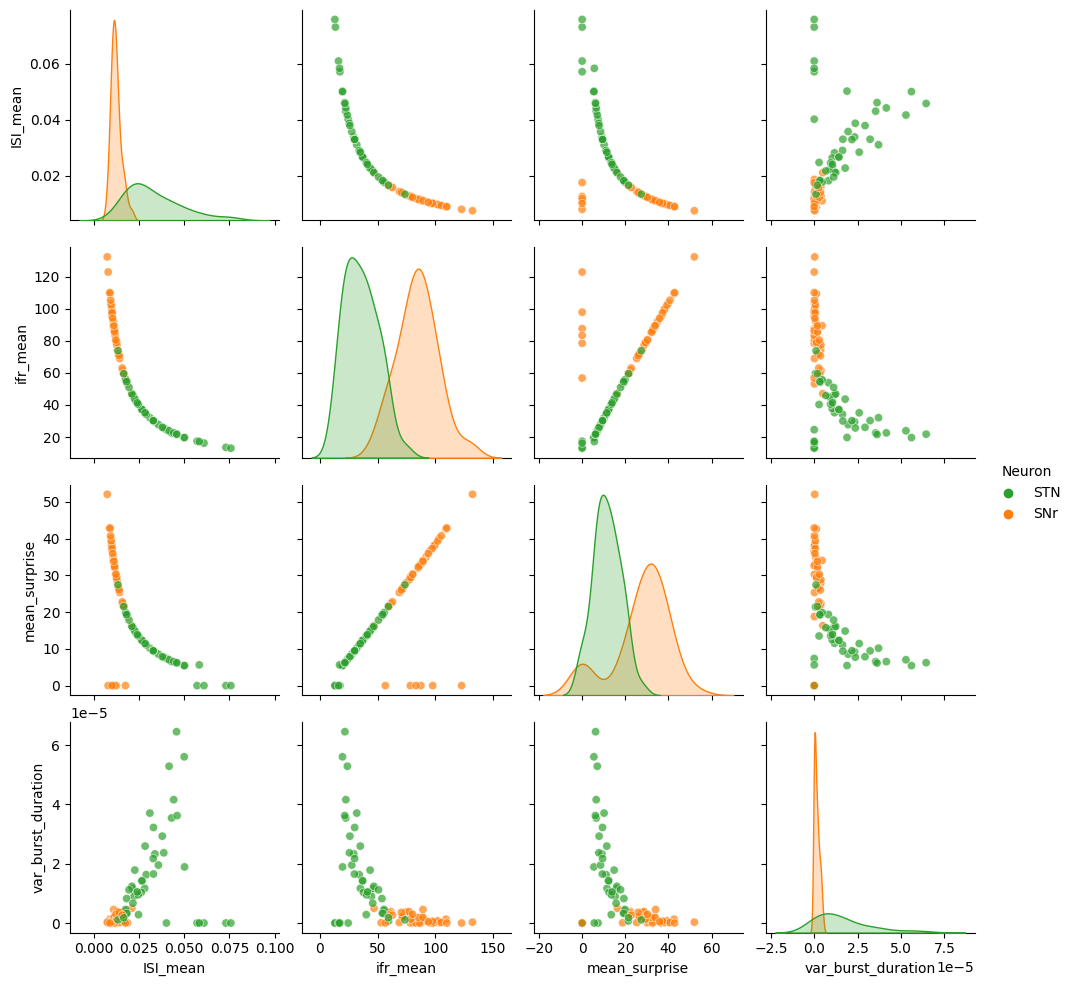

In [160]:
fig = sns.pairplot(subset_right_STN[['ISI_mean', 'ifr_mean', 'mean_surprise','Neuron','var_burst_duration']],hue='Neuron',plot_kws=dict(alpha=0.7),palette=['tab:green','tab:orange'])
fig.savefig('Pairplot_right_STN.svg')

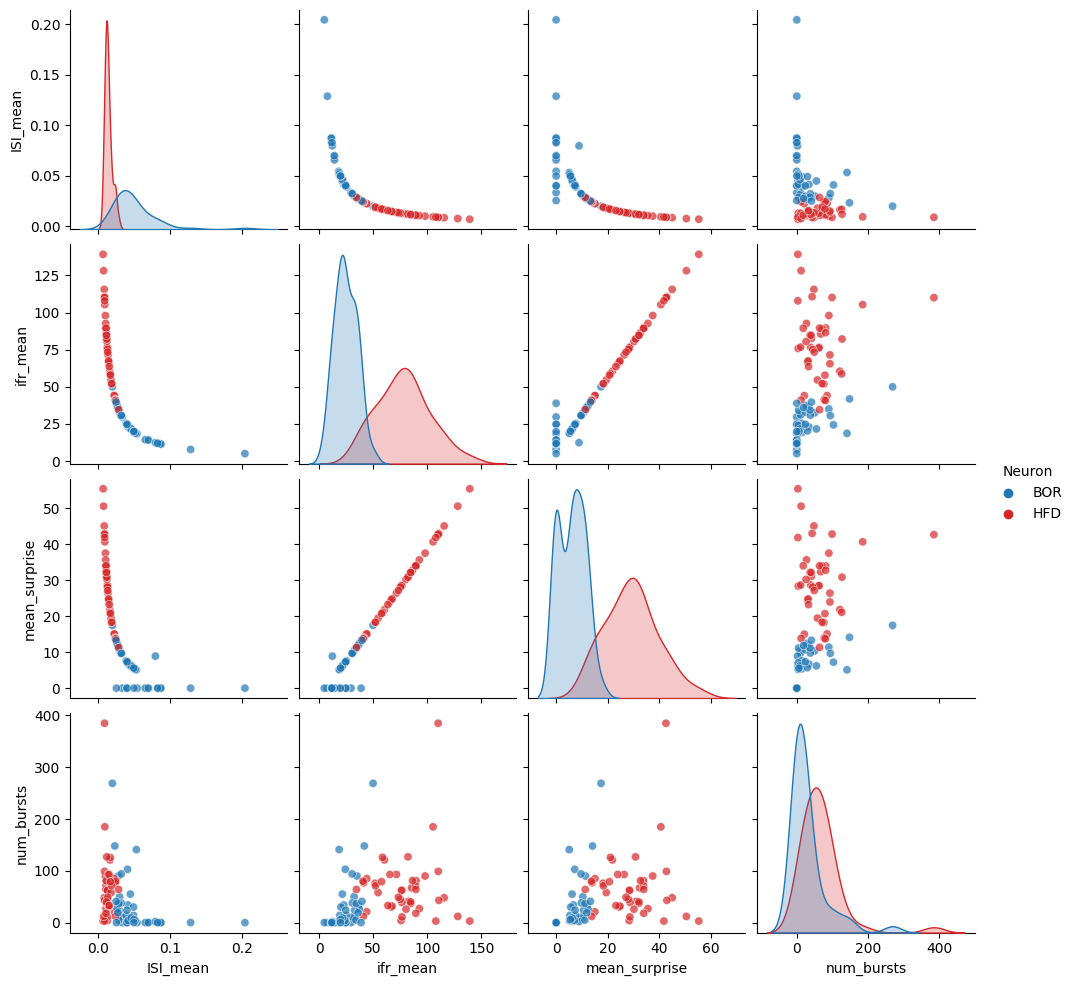

In [161]:
fig = sns.pairplot(subset_right_GPi[['ISI_mean', 'ifr_mean', 'mean_surprise','Neuron','num_bursts']],hue='Neuron',plot_kws=dict(alpha=0.7),palette=['tab:blue','tab:red'])
fig.savefig('Pairplot_right_GPi.svg')

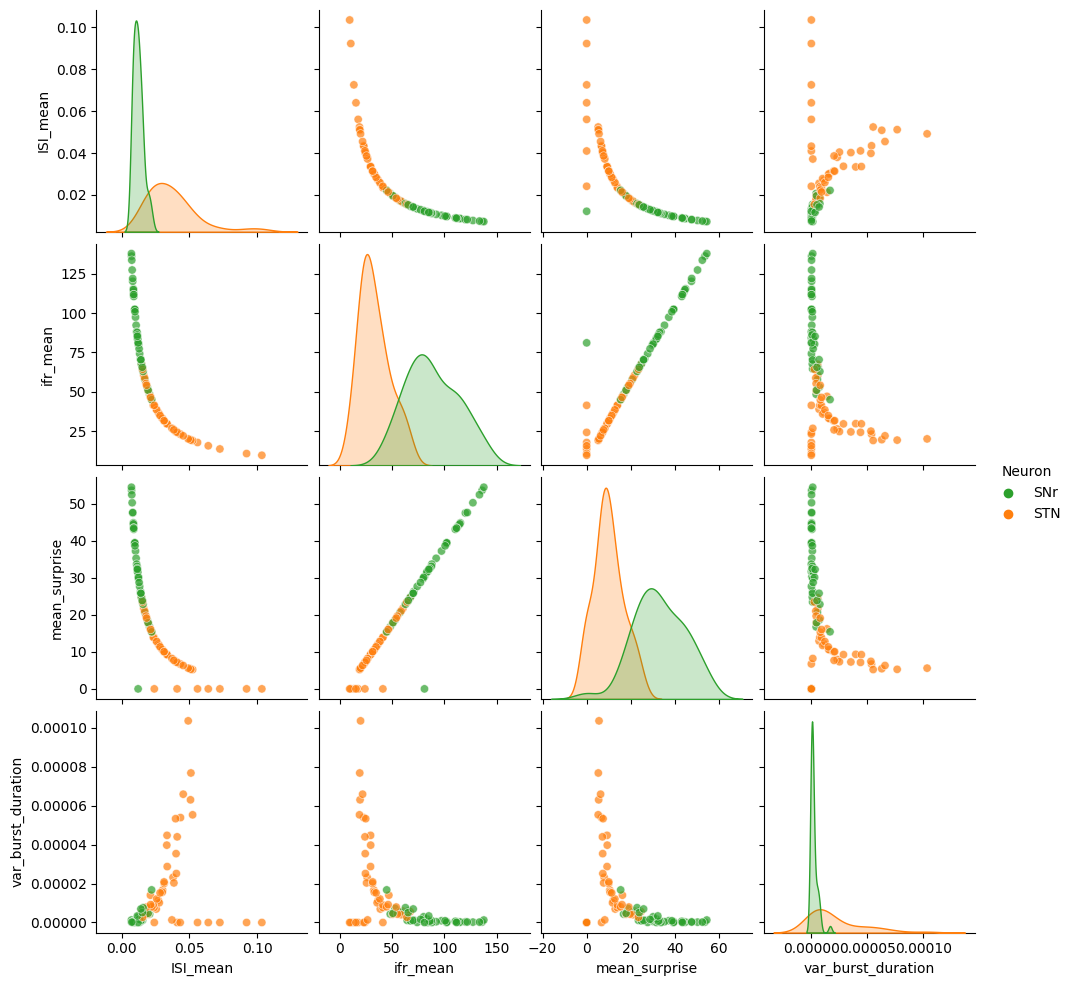

In [162]:
fig = sns.pairplot(subset_left_STN[['ISI_mean', 'ifr_mean', 'mean_surprise','Neuron','var_burst_duration']],hue='Neuron',plot_kws=dict(alpha=0.7),palette=['tab:green','tab:orange'])
fig.savefig('Pairplot_left_STN.svg')

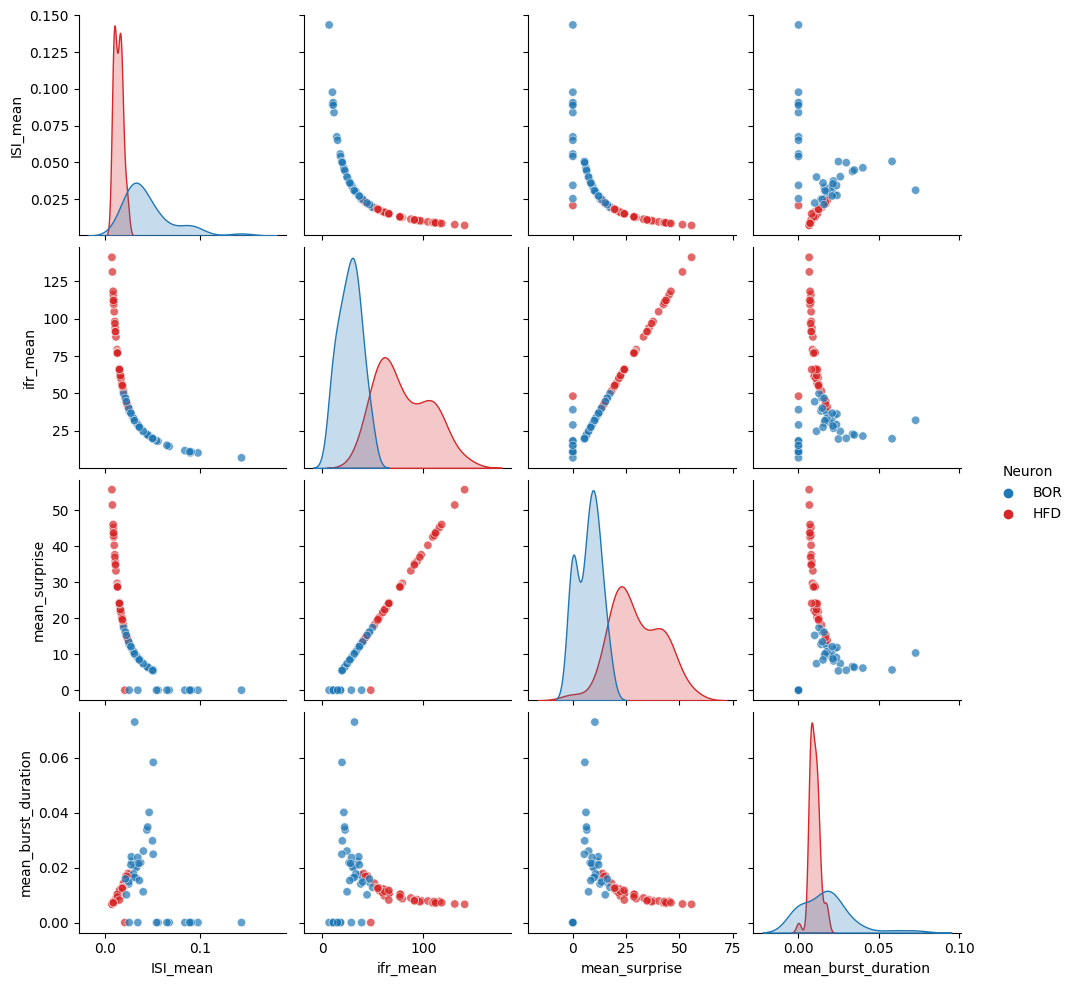

In [180]:
subset_left_GPi_nooutlier = subset_left_GPi.loc[subset_left_GPi['outlier']==0]
fig = sns.pairplot(subset_left_GPi_nooutlier[['ISI_mean', 'ifr_mean', 'mean_surprise','Neuron','mean_burst_duration']],hue='Neuron',plot_kws=dict(alpha=0.7),palette=['tab:blue','tab:red'])
fig.savefig('Pairplot_left_GPi.svg')

In [178]:
outlier_min = np.mean(subset_left_GPi['mean_burst_duration']) - 2* np.std(subset_left_GPi['mean_burst_duration'])
outlier_max = np.mean(subset_left_GPi['mean_burst_duration']) + 2* np.std(subset_left_GPi['mean_burst_duration'])
subset_left_GPi['outlier'] = 0
for i,val in enumerate(subset_left_GPi['mean_burst_duration']):
    if val < outlier_min or val > outlier_max:
        subset_left_GPi['outlier'].iloc[i] = 1

/var/folders/hg/11zt_k_x3xl_zyjfsf79w32c0000gn/T/ipykernel_99140/990799081.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_left_GPi['outlier'].iloc[i] = 1


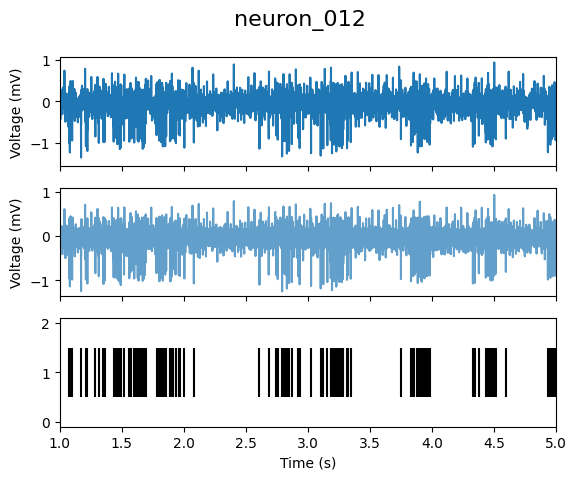

In [267]:
from scipy.signal import find_peaks, butter, filtfilt
lowcut = 300  # Low cutoff frequency in Hz
highcut = 6000  # High cutoff frequency in Hz
fs = 12500  # Sampling frequency in Hz

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

neuron_name = 'neuron_012'
analogsignal, spike_times, sampling_frequency, time = load_spiketrain(os.path.join(data_dir, neuron_name + '.smr'))
filtered_data = butter_bandpass_filter(analogsignal, lowcut, highcut, fs)

##### PLOT SIGNALS #####

fig, ax = plt.subplots(3, sharex = True, )
fig.suptitle(neuron_name, fontsize=16)    

ax[0].plot(time,analogsignal,'tab:blue')
ax[0].set_xlim(1,5)
ax[0].set_ylabel('Voltage (mV)')

ax[1].plot(time,filtered_data,'tab:blue', alpha=0.7)
ax[1].set_ylabel('Voltage (mV)')

ax[2].eventplot(spike_times, color='black')
ax[2].set_xlabel("Time (s)")
fig.savefig('Example_filtering.svg')

# fig, ax = plt.subplots(3, sharex = True, )
# fig.suptitle(neuron_name, fontsize=16)    

# ax[0].plot(time,analogsignal,'tab:blue')
# ax[0].set_xlim(3,3.5)
# ax[0].set_ylabel('Voltage')

# ax[1].plot(time,filtered_data,'tab:blue', alpha=0.7)
# ax[1].set_ylabel('Voltage')

# ax[2].eventplot(spike_times, color='black')
# ax[2].set_xlabel("Time (s)")

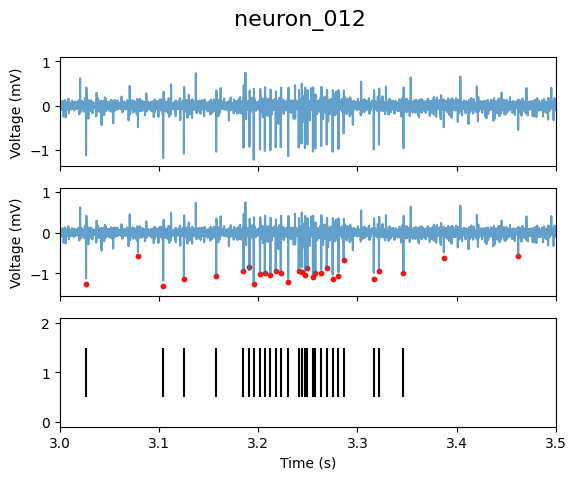

In [268]:
spike_peaks, _ = find_peaks(-filtered_data, height=-np.percentile(filtered_data,0.7))

fig, ax = plt.subplots(3, sharex = True, )
fig.suptitle(neuron_name, fontsize=16)    

ax[0].plot(time,filtered_data,'tab:blue',alpha=0.7)
ax[0].set_xlim(3,3.5)
ax[0].set_ylabel('Voltage (mV)')
ax[1].plot(time,filtered_data,'tab:blue',alpha=0.7)
ax[1].scatter(spike_peaks/sampling_frequency,analogsignal[spike_peaks], color='red',s=10,alpha=0.9)
ax[1].set_ylabel('Voltage (mV)')
ax[2].eventplot(spike_times, color='black')
ax[2].set_xlabel("Time (s)")
fig.savefig('Example_spiketrain.svg')


2


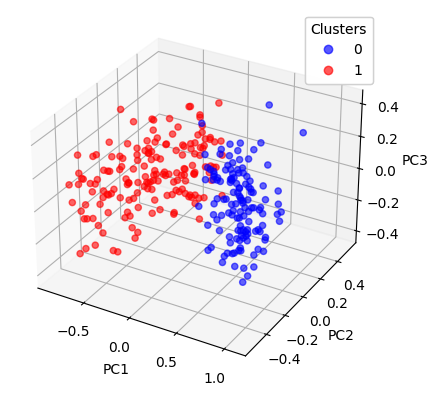

In [249]:
spike_waveforms = np.zeros((len(spike_times),50))
window_size = 25
for i,peak in enumerate(spike_times):
    spike_waveforms[i,:] = filtered_data[int(peak*12500) - window_size: int(peak*12500) + window_size]

# Apply PCA for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
pca = PCA(n_components=3)
waveform_features = pca.fit_transform(spike_waveforms)

si_score = []
cluster_numbers = [2,3,4,5]
for n_clusters in cluster_numbers:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
    cluster_labels = kmeans.fit_predict(waveform_features)
    si_score.append(silhouette_score(waveform_features, cluster_labels, metric='euclidean'))
    
opt_n_clusters = cluster_numbers[np.argmax(si_score)]
print(opt_n_clusters)

kmeans = KMeans(n_clusters=opt_n_clusters, random_state=0, n_init='auto')
cluster_labels = kmeans.fit_predict(waveform_features)
fig = plt.figure()
ax = plt.axes(projection='3d')
scatter = ax.scatter(waveform_features[:,0], waveform_features[:,1], waveform_features[:,2],c=cluster_labels,cmap='bwr',alpha=0.6)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
fig.savefig('Example_neuron_sortfeatures.svg')

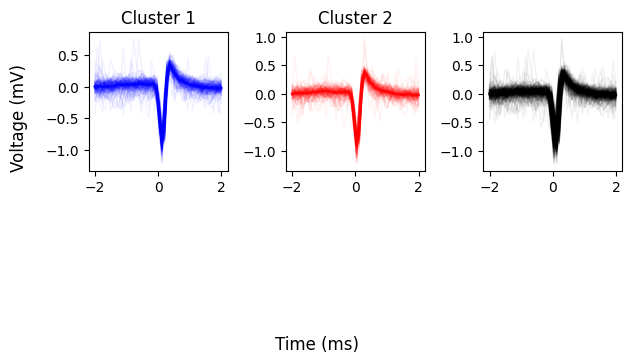

In [271]:
fig,axes=plt.subplots(1,3,)
cluster_waveforms1 = spike_waveforms[cluster_labels == 1,:]
for spike in range(len(cluster_waveforms1)):
    axes[0].plot([i for i in np.linspace(-2,2,50)],cluster_waveforms1[spike,:],alpha=0.05,color = 'blue',linewidth=1)
axes[0].plot([i for i in np.linspace(-2,2,50)],np.mean(cluster_waveforms1,axis=0), color='blue',linewidth=2,alpha=0.8)
axes[0].set_box_aspect(1)

cluster_waveforms2 = spike_waveforms[cluster_labels == 0,:]
for spike in range(len(cluster_waveforms2)):
     axes[1].plot([i for i in np.linspace(-2,2,50)],cluster_waveforms2[spike,:],alpha=0.05,color = 'red',linewidth=1)
axes[1].plot([i for i in np.linspace(-2,2,50)],np.mean(cluster_waveforms2,axis=0), color='red',linewidth=2,alpha=0.8)
axes[1].set_box_aspect(1)
axes[0].set_title('Cluster 1')
axes[1].set_title('Cluster 2')

for spike in range(len(spike_waveforms)):
     axes[2].plot([i for i in np.linspace(-2,2,50)],spike_waveforms[spike,:],alpha=0.05,color = 'black',linewidth=1)
axes[2].plot([i for i in np.linspace(-2,2,50)],np.mean(spike_waveforms,axis=0), color='black',linewidth=2,alpha=0.8)
axes[2].set_box_aspect(1)

fig.supxlabel('Time (ms)')
fig.supylabel('Voltage (mV)')
fig.tight_layout()
fig.savefig('Example_cluster.svg')
# for spike in range(len(spike_waveforms)):
#     plt.plot(spike_waveforms[spike,:],alpha=0.1,color='tab:blue',linewidth = 1)
    
# plt.plot(np.mean(spike_waveforms,axis=0),color='black')

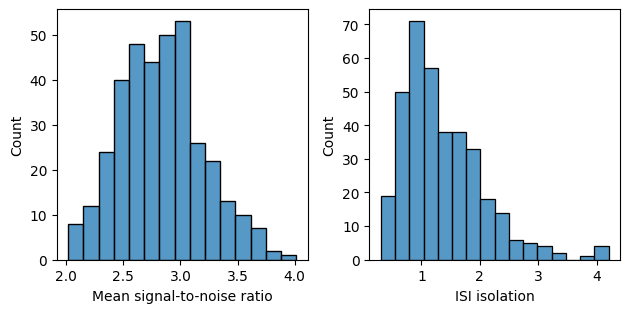

In [286]:
window=25
snr_ls = []
isi_isol_ls = []
mean_isi_ls = []
num_refrac_ls = [] 
for file in os.listdir(data_dir):
    if file.endswith('.smr'):
        analogsignal, spike_times, sampling_frequency, time = load_spiketrain(os.path.join(data_dir,file))
        waveforms = np.zeros((len(spike_times), window*2))
        for i, spike in enumerate(spike_times):
            if spike*sampling_frequency - window >= 0 and spike*sampling_frequency + window <= len(analogsignal):
                waveforms[i,:] = analogsignal[int(spike*sampling_frequency)-window:int(spike*sampling_frequency)+window]
        
        waveforms = waveforms[~np.all(waveforms == 0, axis=1)]
        mean_waveform = np.mean(waveforms,axis=0)
        snr = (np.max(mean_waveform) - np.min(mean_waveform) )/ (np.std(mean_waveform) * 2)
        snr_ls.append(snr)
        
        ISI = np.diff(spike_times)
        ISI_cv = np.std(ISI) / np.mean(ISI)
        isi_isol_ls.append(1/ISI_cv)
        mean_isi_ls.append(np.mean(ISI))
        
        num_refrac_ls.append(len(ISI[ISI<=0.001]))

fig,ax=plt.subplots(1,2)        
sns.histplot(snr_ls,ax=ax[0])
sns.histplot(isi_isol_ls,ax=ax[1])
# sns.histplot(num_refrac_ls,ax=ax[2])
# ax[1].axvline(x=0.001)
# ax[1].set_xlim(0,0.1)

ax[0].set_xlabel('Mean signal-to-noise ratio')
ax[1].set_xlabel('ISI isolation')

ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)

fig.tight_layout()
fig.savefig('spikesort_metrics.svg')